In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..")                    # Consistent with 01 and 02 notebooks
DATA = ROOT / "StudentProjectData"
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

 Loader Utilities

In [11]:
# %%
def load_txt_matrix(path):
    """
    Loads a text file into a NumPy array.
    If the first line contains commas, treat it as CSV.
    Else treat as whitespace-separated text.
    """
    text = open(path).read()
    if "," in text.splitlines()[0]:
        return np.loadtxt(path, delimiter=",")
    return np.loadtxt(path)

def load_classification(i):
    """
    Load TrainData{i}, TrainLabel{i}, TestData{i}.
    Returns:
        X_train : (n_train, d)
        y_train : (n_train,)
        X_test  : (n_test, d)
    """
    X_train = load_txt_matrix(DATA / f"TrainData{i}.txt")
    y_train = load_txt_matrix(DATA / f"TrainLabel{i}.txt")
    X_test  = load_txt_matrix(DATA / f"TestData{i}.txt")
    return X_train, y_train.astype(int), X_test

Missing Value Handling (direct reuse from 02_missing_value.ipynb)

In [12]:
# %%
MISSING_MARKER = 1e99

def replace_missing_marker(X, marker=MISSING_MARKER):
    """
    Replace the 1e99 placeholder with np.nan for proper missing-value handling.
    """
    X = X.astype(float).copy()
    X[X == marker] = np.nan
    return X

In [13]:
print("Checking missing values in classification datasets (1e99 marker)...\n")
for i in range(1, 5):
    X_train, y_train, X_test = load_classification(i)
    
    train_missing = np.sum(X_train == MISSING_MARKER)
    test_missing  = np.sum(X_test  == MISSING_MARKER)

    print(f"Dataset {i}:")
    print(f"   Train missing values: {train_missing}")
    print(f"   Test missing values : {test_missing}\n")

Checking missing values in classification datasets (1e99 marker)...

Dataset 1:
   Train missing values: 9936
   Test missing values : 7021

Dataset 2:
   Train missing values: 0
   Test missing values : 0

Dataset 3:
   Train missing values: 1886
   Test missing values : 0

Dataset 4:
   Train missing values: 0
   Test missing values : 0



KNN Imputation

In [14]:
def knn_impute(X, k):
    """
    KNN Imputation for missing values (np.nan) in a 2D NumPy matrix.

    PARAMETERS:
        X : 2D numpy array, shape (num_rows, num_features)
            Contains real numbers and np.nan marking missing entries.

        k : int
            Number of neighbors to use for imputation.

    RETURNS:
        X_filled : 2D numpy array of same shape as X
            All np.nan replaced via KNN or column-mean fallback.
    """
    # 1. Create a copy of the original array:
    X_filled = X.copy()
    
    # 2. Identify which rows contain missing values
    #    This avoids scanning full rows multiple times unnecessarily.
    row_has_missing = np.isnan(X_filled).any(axis=1)
    
    # 3. Loop over rows
     # 3. Loop through each row (each sample)
    for i in range(X_filled.shape[0]):

        # If row i has no missing values → skip it
        if not row_has_missing[i]:
            continue

        # Extract the row vector
        row = X_filled[i]

        # Boolean masks: which features in this row are missing or valid
        missing_mask = np.isnan(row)      # True where row[i,f] is nan
        valid_mask   = ~missing_mask      # True where row[i,f] is known

        # If the row has *no valid features* at all (very rare),
        # we CANNOT compute distances with any neighbor.
        if valid_mask.sum() == 0:
            # Fallback: fill *every* missing feature with global column mean
            missing_cols = np.where(missing_mask)[0]
            for c in missing_cols:
                col_vals = X_filled[:, c]
                X_filled[i, c] = np.nanmean(col_vals)
            continue
        
        # 3.1 Build candidate neighbors:
        # rows that do NOT have missing values in valid features and are not i
        candidate_indices = []
        for j in range(X_filled.shape[0]):
            if j == i:
                continue  # skip itself

            other = X_filled[j]

            # We require that the neighbor row has NO missing values
            # in the "valid" dimensions of this row.
            # If it has missing in those dims → we CANNOT compare on equal footing.
            if np.isnan(other[valid_mask]).any():
                continue

            candidate_indices.append(j)
        
        # IF NO CANDIDATES EXIST → COLUMN MEAN FALLBACK
        if len(candidate_indices) == 0:
            # Identify missing columns for row i
            missing_cols = np.where(missing_mask)[0]

            # For each missing feature, fill using global column mean
            for c in missing_cols:
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean

            continue  # finished imputing row i; move to next row
        
        # 3.2 Compute distances vectorized over candidates
        # shape: (num_candidates, num_valid_features)
        # Extract only rows of candidate neighbors
        # but keep *only valid features* for distance computation
        candidate_matrix = X_filled[candidate_indices][:, valid_mask]
        
        # Target vector = row i, but only valid dims
        target_vector = row[valid_mask]
        
        # Compute differences between ALL candidates and the target
        diffs = candidate_matrix - target_vector  # broadcasting
        
        # Euclidean distance along feature axis
        dists = np.linalg.norm(diffs, axis=1)
        
        # 3.3 Choose up to k nearest neighbors
        order = np.argsort(dists)               # sorted by distance
        k_eff = min(k, len(order))              # handle case k > available neighbors
        local_neighbor_indices = order[:k_eff]  # local positions in candidate list
        
        # Convert local candidate positions → actual row indices
        neighbor_indices = [candidate_indices[idx] for idx in local_neighbor_indices]

        
        # 3.4 Impute each missing feature
        missing_cols = np.where(missing_mask)[0]
        
        for c in missing_cols:
            vals = []
            
            # Collect each neighbor's value in this column
            for ni in neighbor_indices:
                v = X_filled[ni, c]
                if not np.isnan(v):
                    vals.append(v)
            
            # Convert vals to array
            vals = np.array(vals)
            
            # Case 1: All neighbors have nan in this column → fallback again
            if vals.size == 0:
                 # fallback: global column mean for feature c
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean
                
            # Case 2: Normal case → average neighbor values
            else:
                X_filled[i, c] = np.mean(vals)
                
    return X_filled        
            

Helper Functions for Imputation K-selection (RMSE)

In [15]:
# ### 2.2 K-selection for Imputation (RMSE vs K)
# 
# We follow the same idea as in 02_missing_value.ipynb:
# - Work only on the *training* matrix X_train for a dataset.
# - Find rows with no missing values ("complete rows").
# - Hide a random subset of observed entries from those rows.
# - Impute the hidden values using different K.
# - Compare imputed values with original values → RMSE.
# - Choose the K with smallest RMSE.

# %%
def get_complete_rows(X):
    """
    Return indices of rows that contain NO missing values.
    """
    return np.where(~np.isnan(X).any(axis=1))[0]

def mask_from_complete_rows(X, complete_rows, fraction=0.05, seed=0):
    """
    Hide a fraction of observed entries ONLY in the complete rows.
    Returns:
        X_masked         : copy of X with some entries set to np.nan
        hidden_positions : list of (row, col) indices of hidden entries
    """
    rng = np.random.default_rng(seed)

    # All observed positions (non-NaN) in X
    observed = np.argwhere(~np.isnan(X))

    # Filter to only positions in complete rows
    observed = np.array([pos for pos in observed if pos[0] in complete_rows])

    # Number of positions to hide
    n_hide = int(len(observed) * fraction)
    chosen = rng.choice(len(observed), n_hide, replace=False)
    hidden_positions = observed[chosen]

    # Create masked copy
    X_masked = X.copy()
    for r, c in hidden_positions:
        X_masked[r, c] = np.nan

    return X_masked, hidden_positions

def evaluate_imputation_k(X, k, fraction=0.05, seed=0):
    """
    Evaluate K for imputation:
    - Works on matrix X (with NaNs).
    - Restrict hiding to rows that are fully observed.
    - Mask some known entries.
    - Impute with knn_impute using this K.
    - Compute RMSE on the hidden entries.
    """
    complete_rows = get_complete_rows(X)
    if len(complete_rows) == 0:
        # No complete rows → cannot evaluate; return big error
        return np.inf

    X_masked, hidden_positions = mask_from_complete_rows(
        X, complete_rows, fraction=fraction, seed=seed
    )

    X_imputed = knn_impute(X_masked, k=k)

    # Collect squared errors at hidden positions
    sq_errors = []
    for r, c in hidden_positions:
        true_val = X[r, c]
        pred_val = X_imputed[r, c]
        sq_errors.append((true_val - pred_val) ** 2)

    return np.sqrt(np.mean(sq_errors))

Imputation K-selection for Datasets 1 and 4


Imputation K-selection for Dataset 1


  K=1, RMSE=inf
  K=2, RMSE=inf
  K=3, RMSE=inf
  K=4, RMSE=inf
  K=5, RMSE=inf
  K=6, RMSE=inf
  K=7, RMSE=inf
  K=8, RMSE=inf
  K=9, RMSE=inf
  K=10, RMSE=inf


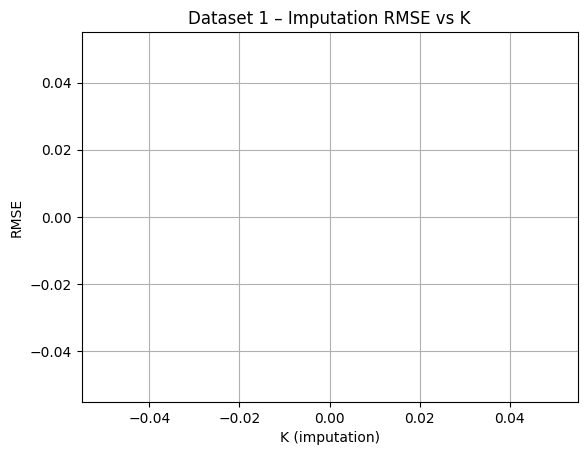

Best K_impute for Dataset 1 = 1

Imputation K-selection for Dataset 3
  K=1, RMSE=1.4254
  K=2, RMSE=1.2569
  K=3, RMSE=1.1809
  K=4, RMSE=1.1545
  K=5, RMSE=1.1199
  K=6, RMSE=1.1206
  K=7, RMSE=1.1039
  K=8, RMSE=1.1084
  K=9, RMSE=1.1072
  K=10, RMSE=1.1029


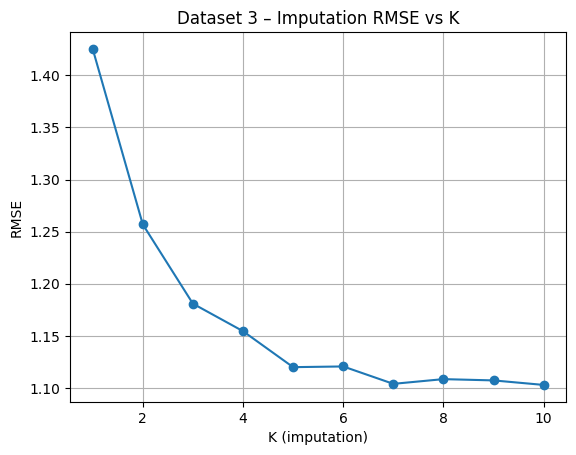

Best K_impute for Dataset 3 = 10


{1: 1, 3: 10}

In [16]:
# ### 2.3 Imputation K-selection for Dataset 1 and 3
# 
# Dataset 1 and 3 have missing values.
# We:
# - Use only the *training* matrix.
# - Convert 1e99 → NaN.
# - Evaluate K from 1 to 10.
# - Plot RMSE vs K.
# - Choose the K with smallest RMSE.

# %%
imputation_k_results = {}

for i in (1, 3):
    print("\n" + "="*40)
    print(f"Imputation K-selection for Dataset {i}")
    X_train_raw, y_train_raw, _ = load_classification(i)
    X_train_nan = replace_missing_marker(X_train_raw)

    Ks = list(range(1, 11))  # 1..10
    rmses = []

    for k in Ks:
        rmse = evaluate_imputation_k(X_train_nan, k=k, fraction=0.05, seed=42)
        rmses.append(rmse)
        print(f"  K={k}, RMSE={rmse:.4f}")

    # Plot RMSE vs K
    plt.figure()
    plt.plot(Ks, rmses, marker='o')
    plt.title(f"Dataset {i} – Imputation RMSE vs K")
    plt.xlabel("K (imputation)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

    # Choose best K (smallest RMSE)
    best_k = Ks[int(np.argmin(rmses))]
    imputation_k_results[i] = best_k
    print(f"Best K_impute for Dataset {i} = {best_k}")

imputation_k_results

In [17]:
# %%
def impute_dataset(X_train, X_test, k_impute=None):
    """
    Replace 1e99 → np.nan, then impute train and test.
    If k_impute is None: use simple column-mean imputation.
    Else: use KNN imputation with k_impute neighbors.
    """
    X_train = replace_missing_marker(X_train)
    X_test  = replace_missing_marker(X_test)

    if k_impute is None:
        col_means = np.nanmean(X_train, axis=0)

        def fill_mean(X):
            X_filled = X.copy()
            inds = np.where(np.isnan(X_filled))
            X_filled[inds] = np.take(col_means, inds[1])
            return X_filled

        return fill_mean(X_train), fill_mean(X_test)

    # KNN imputation
    return knn_impute(X_train, k_impute), knn_impute(X_test, k_impute)

Standardization (Training → Test)

In [18]:
# %%
def compute_standardization_params(X):
    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)
    std[std == 0] = 1.0
    return mean, std

def apply_standardization(X, mean, std):
    return (X - mean) / std

Full Preprocess Function Per Dataset

The Workflow: 

*  Load → replace missing marker → impute → standardize.

In [26]:
def preprocess_dataset(i, imputation_k_dict):
    """
    Preprocess a classification dataset:
      1. Load data
      2. Replace 1e99 → NaN
      3. Impute (mean or KNN)
      4. Standardize using training stats
      5. Convert labels to zero-based for ML models
    """

    # Load
    X_train_raw, y_train, X_test_raw = load_classification(i)

    # Convert labels to zero-based indexing
    unique_labels = np.unique(y_train)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    y_train = np.array([label_map[label] for label in y_train])

    # Pick K for imputation
    k_impute = imputation_k_dict.get(i, None)

    # Impute
    X_train_imp, X_test_imp = impute_dataset(
        X_train_raw, X_test_raw, k_impute=k_impute
    )

    # Standardize
    mean, std = compute_standardization_params(X_train_imp)
    X_train_std = apply_standardization(X_train_imp, mean, std)
    X_test_std  = apply_standardization(X_test_imp,  mean, std)

    return X_train_std, y_train.astype(int), X_test_std

---
#### CLASSIFICATION ALGORITHMS BEGIN:
---

---
#### LOGISTIC REGRESSION (SOFTMAX) CLASSIFIER:
---

#### Softmax Logistic Regression – Core Pieces
 
First we define:
- softmax: turns raw scores into probabilities per class
- one_hot: turns integer labels into one-hot vectors

These are the basic building blocks for multiclass logistic regression.

In [27]:
def softmax(Z):
    """
    Compute softmax for a batch of scores.

    PARAMETERS:
        Z : array of shape (N, C)
            Raw class scores for N samples and C classes.

    RETURNS:
        S : array of shape (N, C)
            Softmax probabilities (each row sums to 1).
    """
    # Numerical stability: subtract row-wise max before exponentiation
    Z_stable = Z - np.max(Z, axis=1, keepdims=True)
    exp_Z = np.exp(Z_stable)
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)


def one_hot(y, num_classes):
    """
    Convert integer labels (shape: (N,)) into one-hot matrix (N, C).

    Example:
        y = [2, 0, 1], num_classes=3
        →
        [[0,1,0],
         [1,0,0],
         [0,1,0]]
    """
    N = len(y)
    Y = np.zeros((N, num_classes))
    Y[np.arange(N), y] = 1
    return Y

#### Intuition: What the Model is Doing

For each class **k** we learn:
- weight vector: w_k  (length = number of features)
- bias: b_k          (scalar)

Given an input vector x (shape (d,)):
- Linear score for class k:   z_k = w_k^T x + b_k
- Collect all z_k into a vector z ∈ R^C
- Apply softmax(z) → probabilities over classes

Training:
- We use **cross-entropy loss**:
  L = - (1/N) * Σ_i log p(y_i | x_i)
- We add optional L2 regularization on W to avoid overfitting.

The gradient is **fully vectorized**:
- Let:
    X : (N, d)
    W : (C, d)
    b : (C,)
    P : softmax(X W^T + b) → (N, C)
    Y : one-hot labels     → (N, C)
- Then:
    dL/dW = (P - Y)^T X / N + 2 * reg * W
    dL/db = sum_rows(P - Y) / N

This is what we implement next.

In [ ]:
#  Softmax Logistic Regression Class
# The class below:
# - stores W and b
# - defines a forward pass (scores + probabilities)
# - computes cross-entropy loss
# - computes gradients w.r.t. W and b
# - runs gradient descent in `fit`
# - predicts labels in `predict`

# %%
class SoftmaxLogisticRegression:
    def __init__(self, num_classes, num_features, lr=0.1, reg=0.0):
        """
        PARAMETERS:
            num_classes  : number of distinct class labels
            num_features : dimensionality of input vectors
            lr           : learning rate for gradient descent
            reg          : L2 regularization strength
        """
        self.num_classes = num_classes
        self.num_features = num_features
        self.lr = lr
        self.reg = reg

        # Initialize weights small and biases to zero
        # W shape: (C, d), b shape: (C,)
        self.W = 0.01 * np.random.randn(num_classes, num_features)
        self.b = np.zeros(num_classes)

    # --------------------------------------------------

    def forward(self, X):
        """
        Compute:
        - scores = X W^T + b
        - probs  = softmax(scores)

        X : (N, d)
        RETURNS:
            scores : (N, C)
            probs  : (N, C)
        """
        scores = X @ self.W.T + self.b
        probs = softmax(scores)
        return scores, probs

    # --------------------------------------------------

    def compute_loss(self, X, y):
        """
        Cross-entropy loss + L2(W) regularization.

        X : (N, d)
        y : (N,) integer labels in {0, 1, ..., C-1}
        """
        N = X.shape[0]
        _, probs = self.forward(X)

        # Cross-entropy on correct classes only
        correct_logprobs = -np.log(probs[np.arange(N), y] + 1e-12)
        data_loss = np.mean(correct_logprobs)

        # L2 regularization on W
        reg_loss = self.reg * np.sum(self.W * self.W)

        return data_loss + reg_loss

    # --------------------------------------------------

    def compute_gradients(self, X, y):
        """
        Compute gradients of loss w.r.t. W and b in vectorized form.
        """
        N = X.shape[0]
        scores = X @ self.W.T + self.b
        probs = softmax(scores)

        # One-hot labels
        Y_onehot = one_hot(y, self.num_classes)

        # dL/d(scores) = (P - Y) / N  for each sample
        dscores = (probs - Y_onehot) / N   # (N, C)

        # dL/dW = dscores^T X
        dW = dscores.T @ X                 # (C, d)

        # Add L2 gradient
        dW += 2 * self.reg * self.W

        # dL/db = sum over rows of dscores
        db = np.sum(dscores, axis=0)       # (C,)

        return dW, db

    # --------------------------------------------------

    def fit(self, X, y, epochs=200, verbose=False):
        """
        Train using full-batch gradient descent.

        RETURNS:
            losses : list of loss values per epoch
        """
        losses = []

        for epoch in range(epochs):
            loss = self.compute_loss(X, y)
            dW, db = self.compute_gradients(X, y)

            # Gradient descent update
            self.W -= self.lr * dW
            self.b -= self.lr * db

            losses.append(loss)

            if verbose and (epoch % 20 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch:3d} | Loss = {loss:.4f}")

        return losses

    # --------------------------------------------------

    def predict(self, X):
        """
        Predict class labels for an array of inputs.

        X : (N, d)
        RETURNS:
            preds : (N,) integer class labels
        """
        scores = X @ self.W.T + self.b
        return np.argmax(scores, axis=1)

Stratified K-Fold and Balanced Accuracy:

#### Stratified K-Fold + Balanced Accuracy

We re-use the same stratified K-fold logic as for KNN:
- keep class proportions similar in each fold
- use balanced accuracy to handle class imbalance

In [40]:
def stratified_kfold(X, y, n_splits=5, seed=42):
    """
    Yield (train_idx, val_idx) pairs for stratified K-fold.
    """
    rng = np.random.RandomState(seed)
    y = y.astype(int)
    classes = np.unique(y)

    # indices per class
    class_indices = {c: np.where(y == c)[0] for c in classes}
    for c in classes:
        rng.shuffle(class_indices[c])

    folds = [[] for _ in range(n_splits)]

    # distribute each class's indices across folds
    for c in classes:
        idxs = class_indices[c]
        fold_sizes = [len(idxs) // n_splits] * n_splits
        for i in range(len(idxs) % n_splits):
            fold_sizes[i] += 1

        start = 0
        for f in range(n_splits):
            end = start + fold_sizes[f]
            folds[f].extend(idxs[start:end])
            start = end

    for f in range(n_splits):
        val_idx = np.array(folds[f])
        train_idx = np.array([idx for i in range(n_splits) if i != f for idx in folds[i]])
        yield train_idx, val_idx


def balanced_accuracy(y_true, y_pred):
    """
    Balanced accuracy = mean recall over classes.
    This treats all classes equally, regardless of support.
    """
    classes = np.unique(y_true)
    recalls = []

    for c in classes:
        mask = (y_true == c)
        if mask.sum() == 0:
            continue
        recall = (y_pred[mask] == c).mean()
        recalls.append(recall)

    return np.mean(recalls)

Logistic Regression Cross-Validation (Hyperparameter Search):

#### Logistic Regression 5-Fold CV (Hyperparameter Search)
We now define a function to:
- loop over a grid of (learning rate, regularization)
- run 5-fold stratified CV for each combo
- compute mean balanced accuracy across folds
- plot per-fold accuracies for up to 6 combinations
- return the best (lr, reg)

In [53]:
def logistic_regression_cv(
    X, y,
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001, 0.01),
    epochs=200,
    n_splits=5,
    plot_cv=False           # <--- NEW ARGUMENT
):
    """
    Perform 5-fold cross-validation for softmax logistic regression.
    Returns:
       best_params  : dict with {'lr':..., 'reg':...}
       cv_scores    : dictionary mapping (lr,reg) → list of fold scores
    """

    y = y.astype(int)
    classes = np.unique(y)
    num_classes  = len(classes)
    num_features = X.shape[1]

    param_grid = []
    for lr in learning_rates:
        for reg in regs:
            param_grid.append((lr, reg))

    # Store all fold scores per hyperparameter pair
    cv_scores = { (lr, reg): [] for lr, reg in param_grid }

    # For plotting each hyperparameter’s 5 fold scores
    n_rows = len(learning_rates)
    n_cols = len(regs)
    fig = None
    if plot_cv:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
        axes = axes.reshape(n_rows, n_cols)
        fig.suptitle("Logistic Regression – 5-Fold CV Balanced Accuracies")

    # Cross-validation
    fold_id = 0
    for train_idx, val_idx in stratified_kfold(X, y, n_splits=n_splits):
        X_tr, y_tr = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        for lr_i, lr in enumerate(learning_rates):
            for reg_j, reg in enumerate(regs):

                model = SoftmaxLogisticRegression(
                    num_classes=num_classes,
                    num_features=num_features,
                    lr=lr,
                    reg=reg
                )

                model.fit(X_tr, y_tr, epochs=epochs, verbose=False)
                pred = model.predict(X_val)

                score = balanced_accuracy(y_val, pred)
                cv_scores[(lr, reg)].append(score)

        fold_id += 1

    # Plot per-hyperparameter fold curves
    if plot_cv:
        for lr_i, lr in enumerate(learning_rates):
            for reg_j, reg in enumerate(regs):
                ax = axes[lr_i, reg_j]
                scores = cv_scores[(lr, reg)]
                ax.plot(range(1, n_splits+1), scores, marker="o")
                ax.set_title(f"lr={lr}, reg={reg}")
                ax.set_xlabel("Fold")
                ax.set_ylabel("Balanced Accuracy")
                ax.grid(True)
        plt.tight_layout()
        plt.show()

    # Find best hyperparameter combination
    avg_scores = { p: np.mean(scores) for p, scores in cv_scores.items() }
    best_lr, best_reg = max(avg_scores, key=avg_scores.get)

    best_params = {"lr": best_lr, "reg": best_reg}

    print("\nHyperparameter Summary:")
    for (lr, reg), vals in cv_scores.items():
        print(f"[lr={lr}, reg={reg}] → Mean Balanced Accuracy = {np.mean(vals):.4f}")

    print(f"\nBest hyperparameters: lr={best_lr}, reg={best_reg}")
    print(f"Best mean balanced accuracy = {avg_scores[(best_lr, best_reg)]:.4f}")

    return best_params, cv_scores

#### Confusion Matrix and Metrics for Logistic Regression

We now define:
- confusion_matrix(y_true, y_pred)
- classification_report(y_true, y_pred)

The report prints:
- confusion matrix
- per-class precision, recall, F1
- macro averages

In [54]:
def confusion_matrix(y_true, y_pred):
    """
    Build confusion matrix where rows = true class, cols = predicted class.
    Assumes labels are 0..C-1.
    """
    classes = np.unique(y_true)
    C = len(classes)
    mat = np.zeros((C, C), dtype=int)

    for t, p in zip(y_true, y_pred):
        mat[t, p] += 1

    return mat


def classification_report(y_true, y_pred):
    """
    Print confusion matrix and per-class precision/recall/F1 + macro averages.
    """
    C = len(np.unique(y_true))
    mat = confusion_matrix(y_true, y_pred)

    print("\nCONFUSION MATRIX (rows=true, cols=pred):")
    print(mat)
    print()

    precisions, recalls, f1s = [], [], []

    for c in range(C):
        tp = mat[c, c]
        fp = mat[:, c].sum() - tp
        fn = mat[c, :].sum() - tp

        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1   = 2 * prec * rec / (prec + rec + 1e-12)

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    print("Per-Class Metrics:")
    print("Class | Precision | Recall | F1")
    for c in range(C):
        print(f"{c:5d} | {precisions[c]:9.3f} | {recalls[c]:6.3f} | {f1s[c]:5.3f}")

    print("\nMacro Averages:")
    print(f"Macro Precision = {np.mean(precisions):.3f}")
    print(f"Macro Recall    = {np.mean(recalls):.3f}")
    print(f"Macro F1        = {np.mean(f1s):.3f}")

In [55]:
# 6. Evaluate on a fresh 80/20 split for reporting
def stratified_train_val_split(X, y, val_ratio=0.2, seed=123):
    rng = np.random.RandomState(seed)
    y = y.astype(int)
    classes = np.unique(y)

    train_idx, val_idx = [], []

    for c in classes:
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        n_val = int(len(idx) * val_ratio)
        val_idx.extend(idx[:n_val])
        train_idx.extend(idx[n_val:])

    train_idx = np.array(train_idx)
    val_idx = np.array(val_idx)

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]


#### Example: Run Logistic Regression on One Dataset

Steps:
1. Choose dataset index i in {1,2,3,4}
2. Decide imputation K (only needed for dataset 3 if it has missing values)
3. Preprocess: impute + standardize
4. Run 5-fold CV to select (lr, reg)
5. Train with best hyperparameters
6. Evaluate on a fresh 80/20 split with confusion matrix and metrics

Training Loss Curve

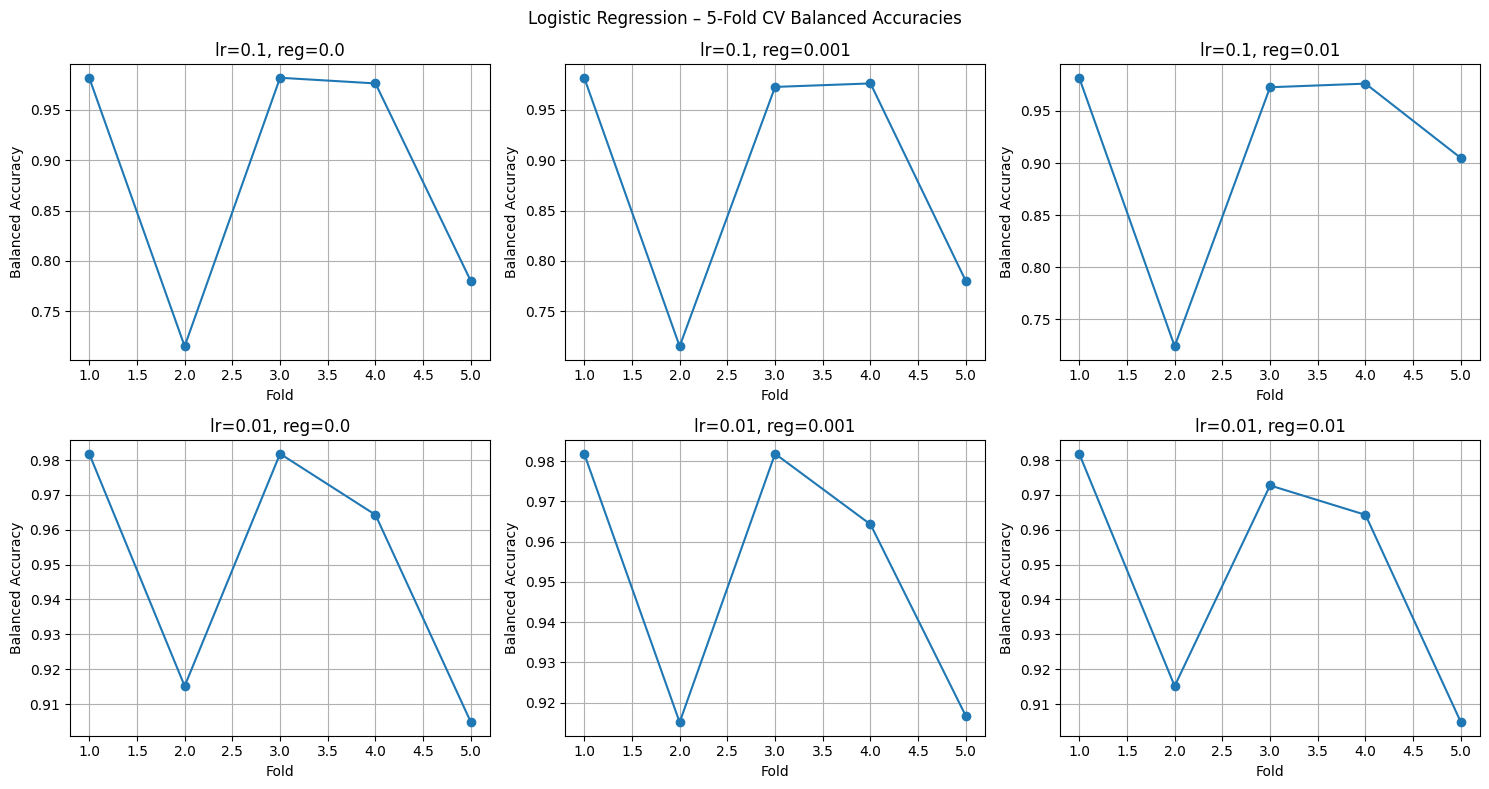


Hyperparameter Summary:
[lr=0.1, reg=0.0] → Mean Balanced Accuracy = 0.8869
[lr=0.1, reg=0.001] → Mean Balanced Accuracy = 0.8851
[lr=0.1, reg=0.01] → Mean Balanced Accuracy = 0.9119
[lr=0.01, reg=0.0] → Mean Balanced Accuracy = 0.9496
[lr=0.01, reg=0.001] → Mean Balanced Accuracy = 0.9519
[lr=0.01, reg=0.01] → Mean Balanced Accuracy = 0.9477

Best hyperparameters: lr=0.01, reg=0.001
Best mean balanced accuracy = 0.9519

Best params for Dataset 1: {'lr': 0.01, 'reg': 0.001}

Epoch   0 | Loss = 1.6688
Epoch  20 | Loss = 0.1854
Epoch  40 | Loss = 0.0937
Epoch  60 | Loss = 0.0592
Epoch  80 | Loss = 0.0430
Epoch 100 | Loss = 0.0338
Epoch 120 | Loss = 0.0280
Epoch 140 | Loss = 0.0240
Epoch 160 | Loss = 0.0211
Epoch 180 | Loss = 0.0188
Epoch 200 | Loss = 0.0171
Epoch 220 | Loss = 0.0157
Epoch 240 | Loss = 0.0145
Epoch 249 | Loss = 0.0141


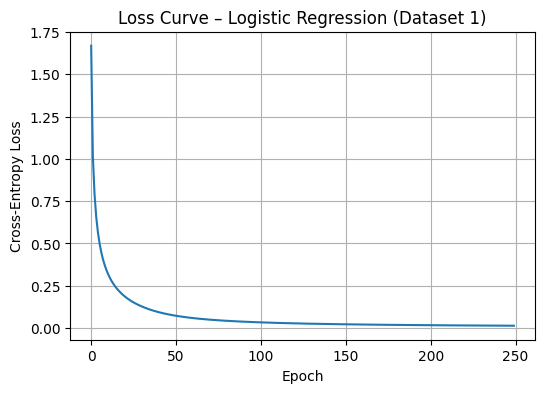


FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[21  0  0  0]
 [ 0  2  0  0]
 [ 0  0  2  0]
 [ 0  0  0  2]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     1.000 |  1.000 | 1.000
    1 |     1.000 |  1.000 | 1.000
    2 |     1.000 |  1.000 | 1.000
    3 |     1.000 |  1.000 | 1.000

Macro Averages:
Macro Precision = 1.000
Macro Recall    = 1.000
Macro F1        = 1.000


In [59]:
# ============================================================
# LOGISTIC REGRESSION PIPELINE FOR ONE DATASET (CHANGE i ONLY)
# ============================================================

i = 1

# ----------------------------------------------
# 1. Imputation settings
# ----------------------------------------------
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# ----------------------------------------------
# 2. Preprocess (impute + standardize)
# ----------------------------------------------
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# ----------------------------------------------
# 3. 5-fold CV Hyperparameter Search
# ----------------------------------------------
best_params, cv_scores = logistic_regression_cv(
    X_train_i,
    y_train_i,
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001, 0.01),
    epochs=200,
    n_splits=5,
    plot_cv=True            
)

print(f"\nBest params for Dataset {i}: {best_params}\n")

# ----------------------------------------------
# 4. Train final model on FULL training set
# ----------------------------------------------
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_model = SoftmaxLogisticRegression(
    num_classes=num_classes,
    num_features=num_features,
    lr=best_params["lr"],
    reg=best_params["reg"]
)

loss_history = final_model.fit(
    X_train_i, y_train_i,
    epochs=250,
    verbose=True
)

# ----------------------------------------------
# 5. Plot final loss curve
# ----------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title(f"Loss Curve – Logistic Regression (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid()
plt.show()

# ----------------------------------------------
# 6. Evaluate on a new 80/20 split
# ----------------------------------------------
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val = final_model.predict(X_val_chk)

print("\nFINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val)

---

Here we see a big drop from 0 --> 50, epochs. The optimal number of epochs wwould be 200 epochs, if it's longer its pointless.

---

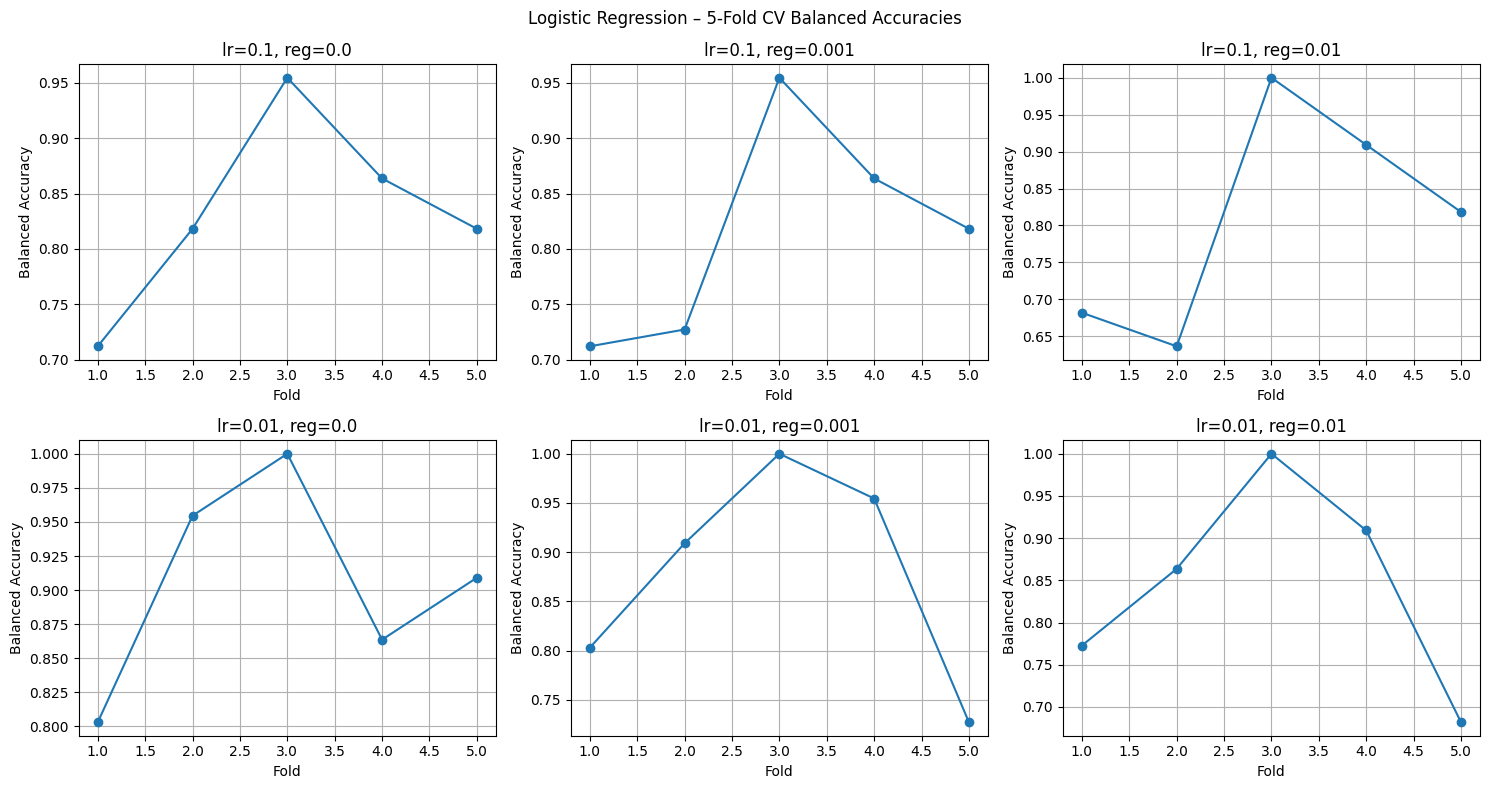


Hyperparameter Summary:
[lr=0.1, reg=0.0] → Mean Balanced Accuracy = 0.8333
[lr=0.1, reg=0.001] → Mean Balanced Accuracy = 0.8152
[lr=0.1, reg=0.01] → Mean Balanced Accuracy = 0.8091
[lr=0.01, reg=0.0] → Mean Balanced Accuracy = 0.9061
[lr=0.01, reg=0.001] → Mean Balanced Accuracy = 0.8788
[lr=0.01, reg=0.01] → Mean Balanced Accuracy = 0.8455

Best hyperparameters: lr=0.01, reg=0.0
Best mean balanced accuracy = 0.9061

Best params for Dataset 2: {'lr': 0.01, 'reg': 0.0}

Epoch   0 | Loss = 2.9289
Epoch  20 | Loss = 0.0256
Epoch  40 | Loss = 0.0126
Epoch  60 | Loss = 0.0084
Epoch  80 | Loss = 0.0063
Epoch 100 | Loss = 0.0050
Epoch 120 | Loss = 0.0042
Epoch 140 | Loss = 0.0036
Epoch 160 | Loss = 0.0032
Epoch 180 | Loss = 0.0028
Epoch 200 | Loss = 0.0025
Epoch 220 | Loss = 0.0023
Epoch 240 | Loss = 0.0021
Epoch 249 | Loss = 0.0020


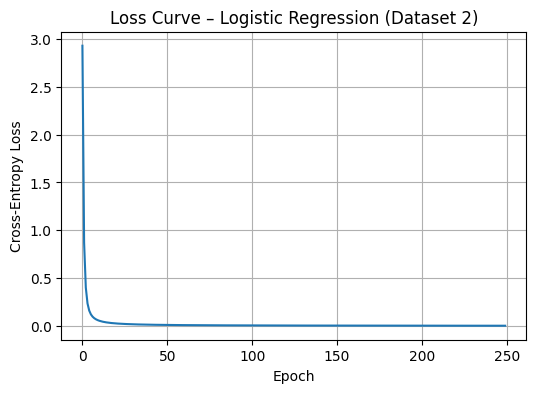


FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     1.000 |  1.000 | 1.000
    1 |     1.000 |  1.000 | 1.000
    2 |     1.000 |  1.000 | 1.000
    3 |     1.000 |  1.000 | 1.000
    4 |     1.000 |  1.000 | 1.000
    5 |     1.000 |  1.000 | 1.000
    6 |     1.000 |  1.000 | 1.000
    7 |     1.000 |  1.000 | 1.000
    8 |     1.000 |  1.000 | 1.000
    9 |     1.000 |  1.000 | 1.000
   10 |     1.000 |  1.000 | 1.000

Macro Averages:
Macro Precision = 1.000
Macro Recall    = 1.000
Macro F1        = 1.000


In [60]:
# ============================================================
# LOGISTIC REGRESSION PIPELINE FOR ONE DATASET (CHANGE i ONLY)
# ============================================================

i = 2 

# ----------------------------------------------
# 1. Imputation settings
# ----------------------------------------------
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# ----------------------------------------------
# 2. Preprocess (impute + standardize)
# ----------------------------------------------
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# ----------------------------------------------
# 3. 5-fold CV Hyperparameter Search
# ----------------------------------------------
best_params, cv_scores = logistic_regression_cv(
    X_train_i,
    y_train_i,
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001, 0.01),
    epochs=200,
    n_splits=5,
    plot_cv=True            
)

print(f"\nBest params for Dataset {i}: {best_params}\n")

# ----------------------------------------------
# 4. Train final model on FULL training set
# ----------------------------------------------
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_model = SoftmaxLogisticRegression(
    num_classes=num_classes,
    num_features=num_features,
    lr=best_params["lr"],
    reg=best_params["reg"]
)

loss_history = final_model.fit(
    X_train_i, y_train_i,
    epochs=250,
    verbose=True
)

# ----------------------------------------------
# 5. Plot final loss curve
# ----------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title(f"Loss Curve – Logistic Regression (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid()
plt.show()

# ----------------------------------------------
# 6. Evaluate on a new 80/20 split
# ----------------------------------------------
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val = final_model.predict(X_val_chk)

print("\nFINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val)

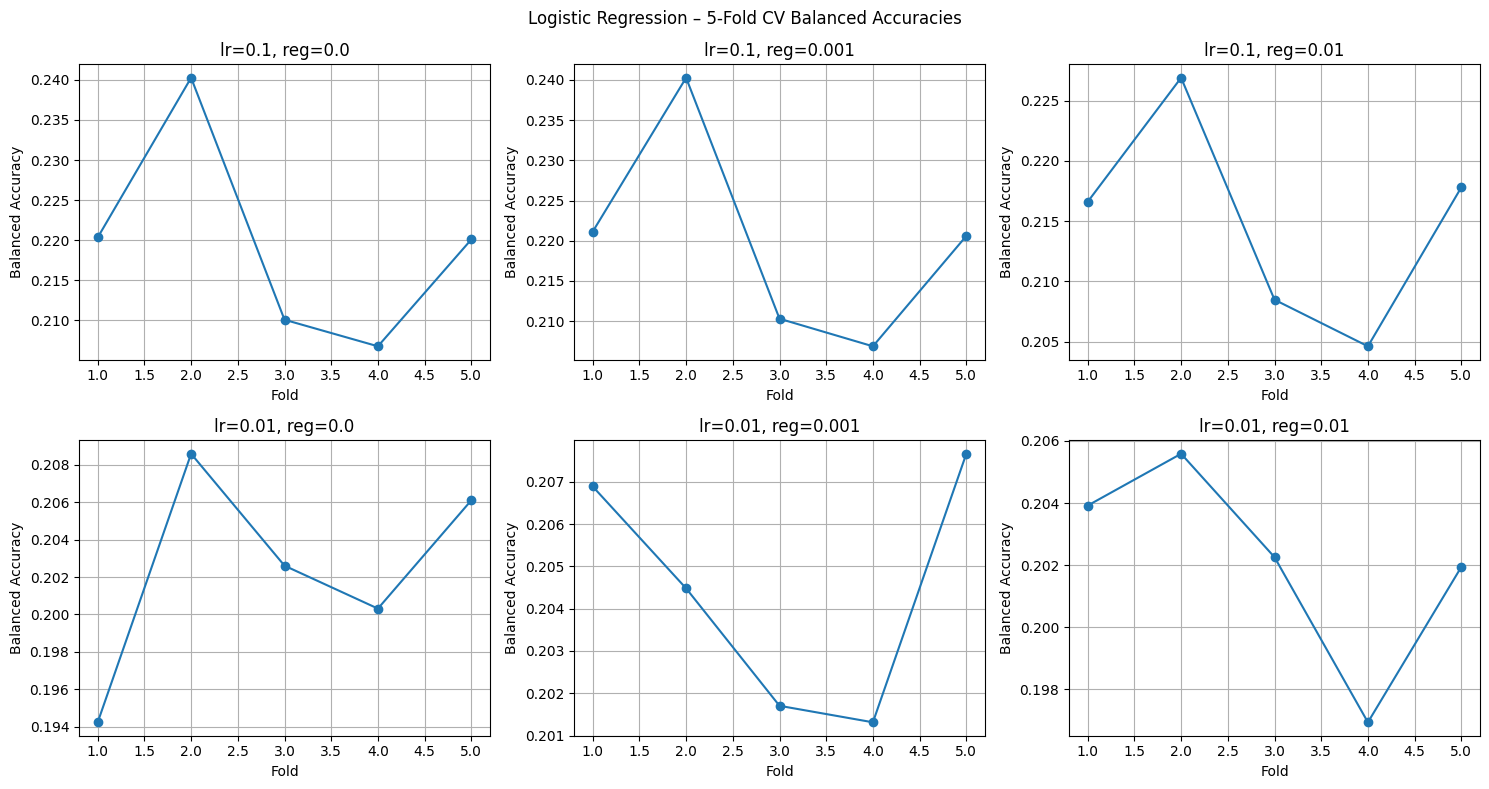


Hyperparameter Summary:
[lr=0.1, reg=0.0] → Mean Balanced Accuracy = 0.2195
[lr=0.1, reg=0.001] → Mean Balanced Accuracy = 0.2198
[lr=0.1, reg=0.01] → Mean Balanced Accuracy = 0.2149
[lr=0.01, reg=0.0] → Mean Balanced Accuracy = 0.2024
[lr=0.01, reg=0.001] → Mean Balanced Accuracy = 0.2044
[lr=0.01, reg=0.01] → Mean Balanced Accuracy = 0.2021

Best hyperparameters: lr=0.1, reg=0.001
Best mean balanced accuracy = 0.2198

Best params for Dataset 3: {'lr': 0.1, 'reg': 0.001}

Epoch   0 | Loss = 2.2034
Epoch  20 | Loss = 1.9549
Epoch  40 | Loss = 1.8978
Epoch  60 | Loss = 1.8750
Epoch  80 | Loss = 1.8620
Epoch 100 | Loss = 1.8535
Epoch 120 | Loss = 1.8476
Epoch 140 | Loss = 1.8432
Epoch 160 | Loss = 1.8399
Epoch 180 | Loss = 1.8373
Epoch 200 | Loss = 1.8353
Epoch 220 | Loss = 1.8337
Epoch 240 | Loss = 1.8323
Epoch 249 | Loss = 1.8318


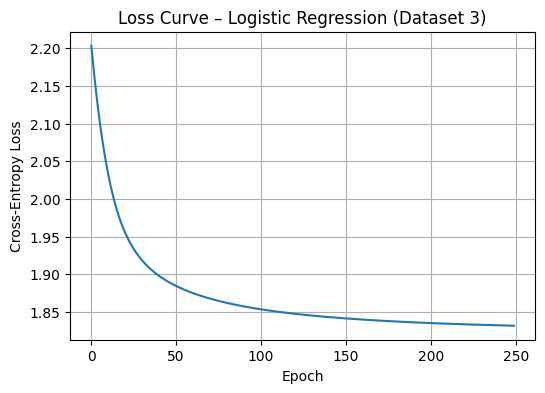


FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[216   6   0   4   0  11   0   7   3]
 [ 71   7   0   7   0   9   1  14   1]
 [ 46   9   0  11   0  14   1  16   0]
 [ 34   4   0  11   0  22   1  36   5]
 [ 20   4   0  17   0  21   2  34   1]
 [ 28   4   0  11   0  32   4  71   5]
 [ 18   2   0  11   0  17   4  81   2]
 [ 24   2   0   2   0  21   2 119  12]
 [ 26   1   0   1   0   4   4  77   6]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     0.447 |  0.874 | 0.592
    1 |     0.179 |  0.064 | 0.094
    2 |     0.000 |  0.000 | 0.000
    3 |     0.147 |  0.097 | 0.117
    4 |     0.000 |  0.000 | 0.000
    5 |     0.212 |  0.206 | 0.209
    6 |     0.211 |  0.030 | 0.052
    7 |     0.262 |  0.654 | 0.374
    8 |     0.171 |  0.050 | 0.078

Macro Averages:
Macro Precision = 0.181
Macro Recall    = 0.220
Macro F1        = 0.168


In [61]:
# ============================================================
# LOGISTIC REGRESSION PIPELINE FOR ONE DATASET (CHANGE i ONLY)
# ============================================================

i = 3 

# ----------------------------------------------
# 1. Imputation settings
# ----------------------------------------------
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# ----------------------------------------------
# 2. Preprocess (impute + standardize)
# ----------------------------------------------
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# ----------------------------------------------
# 3. 5-fold CV Hyperparameter Search
# ----------------------------------------------
best_params, cv_scores = logistic_regression_cv(
    X_train_i,
    y_train_i,
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001, 0.01),
    epochs=200,
    n_splits=5,
    plot_cv=True            
)

print(f"\nBest params for Dataset {i}: {best_params}\n")

# ----------------------------------------------
# 4. Train final model on FULL training set
# ----------------------------------------------
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_model = SoftmaxLogisticRegression(
    num_classes=num_classes,
    num_features=num_features,
    lr=best_params["lr"],
    reg=best_params["reg"]
)

loss_history = final_model.fit(
    X_train_i, y_train_i,
    epochs=250,
    verbose=True
)

# ----------------------------------------------
# 5. Plot final loss curve
# ----------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title(f"Loss Curve – Logistic Regression (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid()
plt.show()

# ----------------------------------------------
# 6. Evaluate on a new 80/20 split
# ----------------------------------------------
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val = final_model.predict(X_val_chk)

print("\nFINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val)

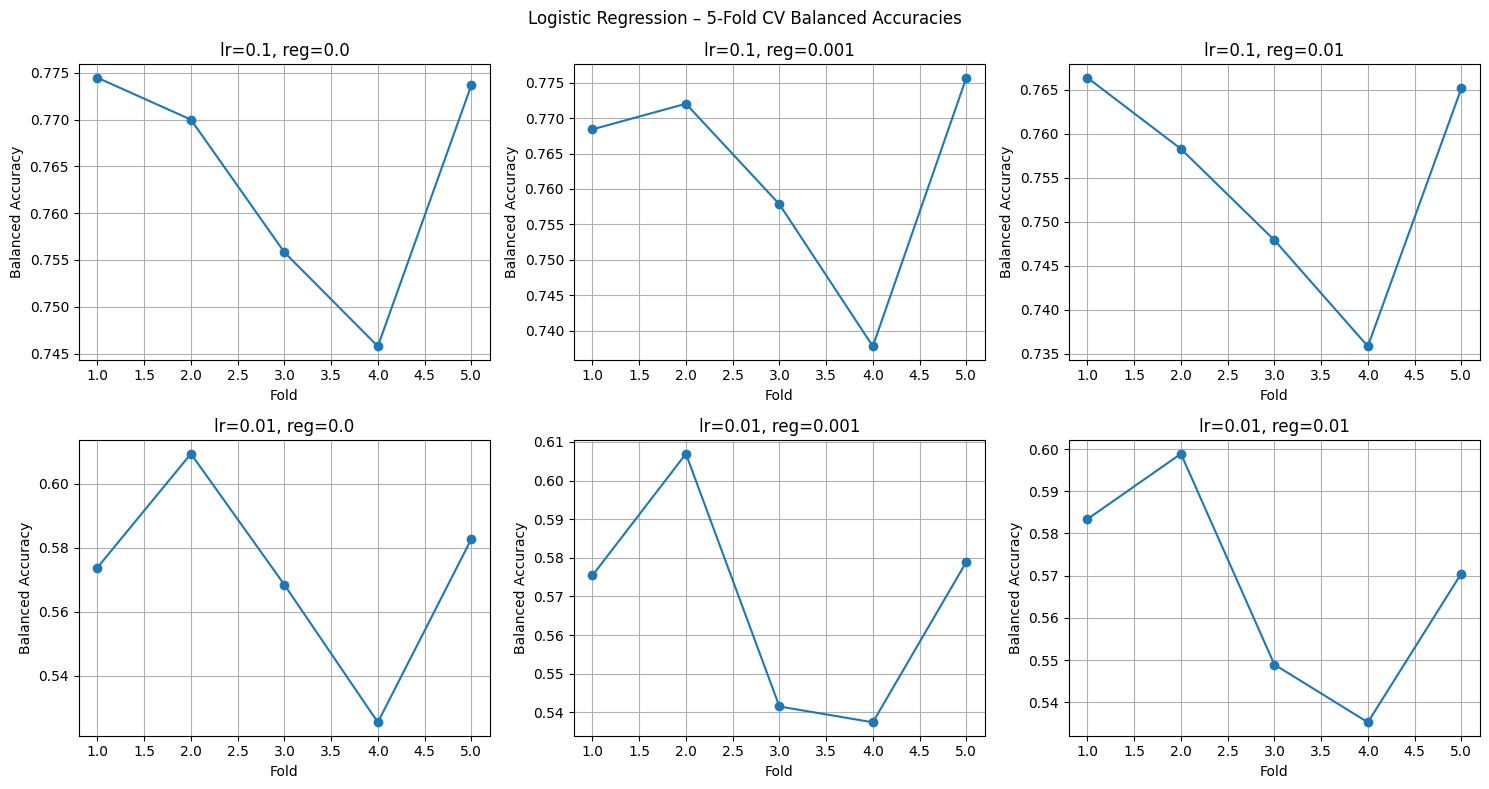


Hyperparameter Summary:
[lr=0.1, reg=0.0] → Mean Balanced Accuracy = 0.7639
[lr=0.1, reg=0.001] → Mean Balanced Accuracy = 0.7624
[lr=0.1, reg=0.01] → Mean Balanced Accuracy = 0.7547
[lr=0.01, reg=0.0] → Mean Balanced Accuracy = 0.5719
[lr=0.01, reg=0.001] → Mean Balanced Accuracy = 0.5681
[lr=0.01, reg=0.01] → Mean Balanced Accuracy = 0.5674

Best hyperparameters: lr=0.1, reg=0.0
Best mean balanced accuracy = 0.7639

Best params for Dataset 4: {'lr': 0.1, 'reg': 0.0}

Epoch   0 | Loss = 2.1961
Epoch  20 | Loss = 1.4191
Epoch  40 | Loss = 1.1711
Epoch  60 | Loss = 1.0313
Epoch  80 | Loss = 0.9378
Epoch 100 | Loss = 0.8695
Epoch 120 | Loss = 0.8166
Epoch 140 | Loss = 0.7741
Epoch 160 | Loss = 0.7389
Epoch 180 | Loss = 0.7091
Epoch 200 | Loss = 0.6835
Epoch 220 | Loss = 0.6611
Epoch 240 | Loss = 0.6413
Epoch 249 | Loss = 0.6331


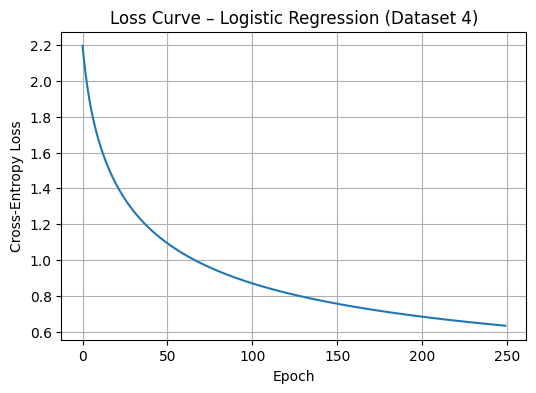


FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[45  5  1  5  0  0  0  0  1]
 [ 4 46  1  1  1  0  1  1  0]
 [ 1  3 44  0  2  1  0  1  2]
 [ 0  0  0 57  1  0  0  0  0]
 [ 2  1  2  4 40  1  3  1  1]
 [ 0  0  2  0  9 43  0  0  3]
 [ 1  0  0  0  0  0 52  3  1]
 [ 0  0  0  0  0  2  3 52  2]
 [ 0  0  0  0  0  2  1  3 48]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     0.849 |  0.789 | 0.818
    1 |     0.836 |  0.836 | 0.836
    2 |     0.880 |  0.815 | 0.846
    3 |     0.851 |  0.983 | 0.912
    4 |     0.755 |  0.727 | 0.741
    5 |     0.878 |  0.754 | 0.811
    6 |     0.867 |  0.912 | 0.889
    7 |     0.852 |  0.881 | 0.867
    8 |     0.828 |  0.889 | 0.857

Macro Averages:
Macro Precision = 0.844
Macro Recall    = 0.843
Macro F1        = 0.842


In [62]:
# ============================================================
# LOGISTIC REGRESSION PIPELINE FOR ONE DATASET (CHANGE i ONLY)
# ============================================================

i = 4 

# ----------------------------------------------
# 1. Imputation settings
# ----------------------------------------------
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# ----------------------------------------------
# 2. Preprocess (impute + standardize)
# ----------------------------------------------
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# ----------------------------------------------
# 3. 5-fold CV Hyperparameter Search
# ----------------------------------------------
best_params, cv_scores = logistic_regression_cv(
    X_train_i,
    y_train_i,
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001, 0.01),
    epochs=200,
    n_splits=5,
    plot_cv=True            
)

print(f"\nBest params for Dataset {i}: {best_params}\n")

# ----------------------------------------------
# 4. Train final model on FULL training set
# ----------------------------------------------
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_model = SoftmaxLogisticRegression(
    num_classes=num_classes,
    num_features=num_features,
    lr=best_params["lr"],
    reg=best_params["reg"]
)

loss_history = final_model.fit(
    X_train_i, y_train_i,
    epochs=250,
    verbose=True
)

# ----------------------------------------------
# 5. Plot final loss curve
# ----------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title(f"Loss Curve – Logistic Regression (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid()
plt.show()

# ----------------------------------------------
# 6. Evaluate on a new 80/20 split
# ----------------------------------------------
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val = final_model.predict(X_val_chk)

print("\nFINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val)